Route : <-> Plant <->  b <-> Home <-> Garage <-> Work <-> B <-> A <->  e <-> Office <->  c <-> Factory <->  a <-> Park <->  d <-> C <->
Distance of tour : 2555.4



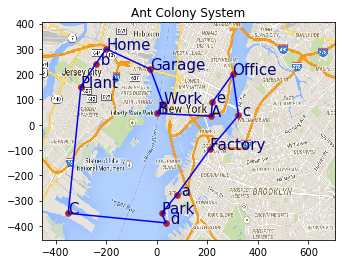

Route : <-> Plant <->  b <-> Home <-> Garage <-> Work <-> B <-> A <->  e <-> Office <->  c <-> Factory <->  a <-> Park <->  d <-> C <->
Distance of tour : 2555.4



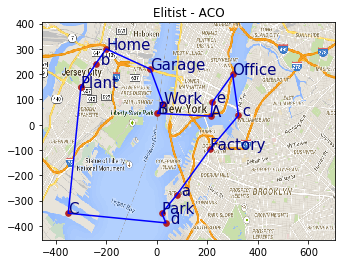

In [369]:
#%matplotlib inline
import csv
import math
import random
from matplotlib import pyplot as plt


def retrieveData():
    data = list(csv.reader(open('datafile.csv')))
    for i in data:
        i[0] = float(i[0])
        i[1] = float(i[1])
    lattitude = [i[0] for i in data]
    longitude = [i[1] for i in data]
    coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
    places = [i[2] for i in data]
    return coordinates, places

def retrievePreviousData():
    data = list(csv.reader(open('prevTour.csv')))[0]
    return data

class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='Ant Colony System', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, labels=None, previous_path=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        
        
        #Use previous Opt - START -------CHANGE TO USE function [13], [14] FROM PAPER-------
        
        #print (labels)
        #print (previous_path)
        if previous_path != None:
            for i in range(len(previous_path)):
                if (previous_path[i-1] in labels) and (previous_path[i] in labels):
                    for j in range(len(labels)):
                        if previous_path[i-1] == labels[j]:
                            for k in range(len(labels)):
                                if previous_path[i] == labels[k]:
                                    self.edges[j][k].pheromone = 2.0
                                    self.edges[k][j].pheromone = 2.0
                                    #print (previous_path[i-1], 'and', previous_path[i], ' ', self.edges[j][k].pheromone)
                    #print (previous_path[i-1], ' to ', previous_path[i])
        #for i in range(self.num_nodes):
            #for j in range(i + 1, self.num_nodes):
                #print (self.edges[i][j].pheromone)
        
        #Use previous Opt - END ---------------------------------------------------
        
        
        
        
        
        
        
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    #print (self.edges[i][j].pheromone)
            #print ('\n \n -------------------------- \n \n')

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def run(self):
        if self.mode == 'Ant Colony System':
            self._acs()
        elif self.mode == 'Elitist - ACO':
            self._elitist()
        print('Route : <-> {0} <->'.format(' <-> '.join(str(self.labels[i]) for i in self.global_best_tour)))
        csv_str = [self.labels[i] for i in self.global_best_tour]
        with open("prevTour.csv",'wb') as resultFile:
            wr = csv.writer(resultFile, dialect='excel')
            wr.writerow(csv_str)
        print('Distance of tour : {0}\n'.format(round(self.global_best_distance, 2)))

    def plot(self, line_width=1.5, point_radius=math.sqrt(2.5), annotation_size=15, dpi=120, save=True, name=None):
        img = plt.imread('ny-map.jpg')
        #img = plt.imread('dearborn_test1.PNG')
        fig, ax = plt.subplots()
        #x = range(300)
        ax.imshow(img, extent=[-455, 705, -455, 405])
        #ax.imshow(img, extent=[-455, 2600, -455, 1200])
        #ax.plot(x, x, '--', linewidth=5, color='firebrick')
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width, color='blue')#color='firebrick')
        plt.scatter(x, y, s=math.pi * (point_radius ** 5.0), color='firebrick')
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size, color='navy')#size=annotation_size)
        if save:
            if name is None:
                name = '{0}_tour.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()


if __name__ == '__main__':
    coordinates, places = retrieveData()
    previous_data = retrievePreviousData()
    _colony_size = 5
    _steps = 150
    _nodes = coordinates#[(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    #_nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    acs = SolveTSPUsingACO(mode='Ant Colony System', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places, previous_path=previous_data)# labels=['a', 'b', 'c', 'd', 'e', 'f'])
    acs.run()
    acs.plot()
    elitist = SolveTSPUsingACO(mode='Elitist - ACO', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places)
    elitist.run()
    elitist.plot()
    #max_min = SolveTSPUsingACO(mode='MaxMin', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    #max_min.run()
    #max_min.plot()


** Store old pheromone values, use function from [13],[14] **

** Create time slices - compare visited vs new and elminate visited nodes and rerun**


* Setting step size *

* Why can't I use random.seed(0) *


In [297]:
import csv
data = list(csv.reader(open('datafile.csv')))
for i in data:
    i[0] = float(i[0])
    i[1] = float(i[1])
lattitude = [i[0] for i in data]
longitude = [i[1] for i in data]
coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
places = [i[2] for i in data]
print (data)
print('lattitude: ', lattitude)
print('longitude: ', longitude)
print('coordinates: ', coordinates)
print('places: ', places)

[[300.0, 200.0, 'Office'], [-300.0, 150.0, 'Plant'], [-200.0, 300.0, 'Home'], [0.0, -350.0, 'Park'], [-25.0, 220.0, 'Garage'], [15.0, 84.0, 'Work'], [210.0, -97.0, 'Factory']]
lattitude:  [300.0, -300.0, -200.0, 0.0, -25.0, 15.0, 210.0]
longitude:  [200.0, 150.0, 300.0, -350.0, 220.0, 84.0, -97.0]
coordinates:  [[300.0, 200.0], [-300.0, 150.0], [-200.0, 300.0], [0.0, -350.0], [-25.0, 220.0], [15.0, 84.0], [210.0, -97.0]]
places:  ['Office', 'Plant', 'Home', 'Park', 'Garage', 'Work', 'Factory']


In [371]:
#Create Data Points (coordinates and locations)
import random 
A=400*random.random()

for i in range(20):
    print (400*random.uniform(-1, 1),', ', 400*random.uniform(-1, 1),',', chr(97+i))

210.681081831 ,  -4.79078545246 , a
-373.071451847 ,  -38.6120679558 , b
231.514439138 ,  -314.262583031 , c
295.987668951 ,  374.683729573 , d
248.282301333 ,  -275.632722464 , e
267.83805636 ,  225.870974664 , f
-51.4180969559 ,  -322.73594385 , g
-205.940268161 ,  -223.230923714 , h
-241.884907364 ,  14.3589720507 , i
23.2934268624 ,  310.250697103 , j
-288.196270016 ,  -241.432295407 , k
44.744552585 ,  326.990210749 , l
177.967781847 ,  -376.692555677 , m
-269.967065773 ,  -125.089410987 , n
198.970453557 ,  350.325782872 , o
153.427785078 ,  68.2011703149 , p
-345.062752123 ,  123.960512404 , q
357.808339222 ,  271.193977106 , r
396.277496933 ,  -361.876484649 , s
268.061981284 ,  121.62862687 , t


In [97]:
from gmplot import gmplot

# Place map
gmap = gmplot.GoogleMapPlotter(42.3046, -83.2320, 13)

# Polygon
golden_gate_park_lats, golden_gate_park_lons = zip(*[
    (42.6679, -83.2082),
    (42.69, -83.25),
    (37.774797, -122.454538),
    (37.771988, -122.454018),
    (37.773646, -122.440979),
    (37.772742, -122.440797),
    (37.771096, -122.453889),
    (37.768669, -122.453518),
    (37.766227, -122.460213),
    (37.764028, -122.510347),
    (37.771269, -122.511015)
    ])
gmap.plot(golden_gate_park_lats, golden_gate_park_lons, 'cornflowerblue', edge_width=10)

# Scatter points
top_attraction_lats, top_attraction_lons = zip(*[
    (42.6779, -83.2282),
    (37.768645, -122.475328),
    (37.771478, -122.468677),
    (37.769867, -122.466102),
    (37.767187, -122.467496),
    (37.770104, -122.470436)
    ])
gmap.scatter(top_attraction_lats, top_attraction_lons, '#3B0B39', size=40, marker=False)

# Marker
hidden_gem_lat, hidden_gem_lon = 42.6679, -83.2082
gmap.marker(hidden_gem_lat, hidden_gem_lon, 'red')

# Draw
gmap.draw("my_map.html")


In [105]:
# import gmplot package
import gmplot
 
latitude_list = [ 42.6679, 42.8, 4.99 ]
longitude_list = [ -83.2, -83, -82.69 ]
 
gmap3 = gmplot.GoogleMapPlotter(42.3046, -83.2320, 13)
 
# scatter method of map object 
# scatter points on the google map
gmap3.scatter( latitude_list, longitude_list, '# FF0000',
                              size = 40, marker = False )
 
# Plot method Draw a line in
# between given coordinates
gmap3.plot(latitude_list, longitude_list, 
           'cornflowerblue', edge_width = 2.5)

# Marker
hidden_gem_lat, hidden_gem_lon = 42.6679, -83.2082
gmap3.marker(hidden_gem_lat, hidden_gem_lon, 'red')
 
gmap3.draw( "map13.html" )

In [104]:
import psycopg2
import gmplot

# Connect to the database
db_conn = psycopg2.connect("dbname='database_name' host='host_address' user='username' password='your_password'")

#Set the cursor
cur = db_conn.cursor()

# Execute the database query. I am fetching business locations in a particular zip.
cur.execute("select latitude, longitude from business where postal_code='89109';")

# Fetch all the data returned by the database query as a list
lat_long = cur.fetchall()

# Initialize two empty lists to hold the latitude and longitude values
latitude = []
longitude = [] 

# Transform the the fetched latitude and longitude data into two separate lists
for i in range(len(lat_long)):
	latitude.append(lat_long[i][0])
	longitude.append(lat_long[i][1])

# Initialize the map to the first location in the list
gmap = gmplot.GoogleMapPlotter(latitude[0],longitude[0])

# Draw the points on the map. I created my own marker for '#FF66666'. 
# You can use other markers from the available list of markers. 
# Another option is to place your own marker in the folder - 
# /usr/local/lib/python3.5/dist-packages/gmplot/markers/
gmap.scatter(latitude, longitude, '#FF6666', edge_width=10)

# Write the map in an HTML file
gmap.draw('map-other.html')

# Close the cursor and the database connection 
cur.close()
db_conn.close()

ImportError: No module named psycopg2

In [91]:
"""Capacitated Vehicle Routing Problem"""
from __future__ import print_function
from six.moves import xrange
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

###########################
# Problem Data Definition #
###########################
class Vehicle():
    """Stores the property of a vehicle"""
    def __init__(self):
        """Initializes the vehicle properties"""
        self._capacity = 15

    @property
    def capacity(self):
        """Gets vehicle capacity"""
        return self._capacity

class CityBlock():
    """City block definition"""
    @property
    def width(self):
        """Gets Block size West to East"""
        return 228/2

    @property
    def height(self):
        """Gets Block size North to South"""
        return 80

class DataProblem():
    """Stores the data for the problem"""
    def __init__(self):
        """Initializes the data for the problem"""
        self._vehicle = Vehicle()
        self._num_vehicles = 4

        # Locations in block unit
        locations = \
                [(4, 4), # depot
                 (2, 0), (8, 0), # row 0
                 (0, 1), (1, 1),
                 (5, 2), (7, 2),
                 (3, 3), (6, 3),
                 (5, 5), (8, 5),
                 (1, 6), (2, 6),
                 (3, 7), (6, 7),
                 (0, 8), (7, 8)]
        # locations in meters using the city block dimension
        city_block = CityBlock()
        self._locations = [(
            loc[0]*city_block.width,
            loc[1]*city_block.height) for loc in locations]

        self._depot = 0

        self._demands = \
            [0, # depot
             1, 1, # row 0
             2, 4,
             2, 4,
             8, 8,
             1, 2,
             1, 2,
             4, 4,
             8, 8]

    @property
    def vehicle(self):
        """Gets a vehicle"""
        return self._vehicle

    @property
    def num_vehicles(self):
        """Gets number of vehicles"""
        return self._num_vehicles

    @property
    def locations(self):
        """Gets locations"""
        return self._locations

    @property
    def num_locations(self):
        """Gets number of locations"""
        return len(self.locations)

    @property
    def depot(self):
        """Gets depot location index"""
        return self._depot

    @property
    def demands(self):
        """Gets demands at each location"""
        return self._demands

#######################
# Problem Constraints #
#######################
def manhattan_distance(position_1, position_2):
    """Computes the Manhattan distance between two points"""
    return (abs(position_1[0] - position_2[0]) +
            abs(position_1[1] - position_2[1]))

class CreateDistanceEvaluator(object): # pylint: disable=too-few-public-methods
    """Creates callback to return distance between points."""
    def __init__(self, data):
        """Initializes the distance matrix."""
        self._distances = {}

        # precompute distance between location to have distance callback in O(1)
        for from_node in xrange(data.num_locations):
            self._distances[from_node] = {}
            for to_node in xrange(data.num_locations):
                if from_node == to_node:
                    self._distances[from_node][to_node] = 0
                else:
                    self._distances[from_node][to_node] = (
                        manhattan_distance(
                            data.locations[from_node],
                            data.locations[to_node]))

    def distance_evaluator(self, from_node, to_node):
        """Returns the manhattan distance between the two nodes"""
        return self._distances[from_node][to_node]

class CreateDemandEvaluator(object): # pylint: disable=too-few-public-methods
    """Creates callback to get demands at each location."""
    def __init__(self, data):
        """Initializes the demand array."""
        self._demands = data.demands

    def demand_evaluator(self, from_node, to_node):
        """Returns the demand of the current node"""
        del to_node
        return self._demands[from_node]

def add_capacity_constraints(routing, data, demand_evaluator):
    """Adds capacity constraint"""
    capacity = "Capacity"
    routing.AddDimension(
        demand_evaluator,
        0, # null capacity slack
        data.vehicle.capacity, # vehicle maximum capacity
        True, # start cumul to zero
        capacity)

###########
# Printer #
###########
class ConsolePrinter():
    """Print solution to console"""
    def __init__(self, data, routing, assignment):
        """Initializes the printer"""
        self._data = data
        self._routing = routing
        self._assignment = assignment

    @property
    def data(self):
        """Gets problem data"""
        return self._data

    @property
    def routing(self):
        """Gets routing model"""
        return self._routing

    @property
    def assignment(self):
        """Gets routing model"""
        return self._assignment

    def print(self):
        """Prints assignment on console"""
        # Inspect solution.
        total_dist = 0
        for vehicle_id in xrange(self.data.num_vehicles):
            index = self.routing.Start(vehicle_id)
            plan_output = 'Route for vehicle {0}:\n'.format(vehicle_id)
            route_dist = 0
            route_load = 0
            while not self.routing.IsEnd(index):
                node_index = self.routing.IndexToNode(index)
                next_node_index = self.routing.IndexToNode(
                    self.assignment.Value(self.routing.NextVar(index)))
                route_dist += manhattan_distance(
                    self.data.locations[node_index],
                    self.data.locations[next_node_index])
                route_load += self.data.demands[node_index]
                plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
                index = self.assignment.Value(self.routing.NextVar(index))

            node_index = self.routing.IndexToNode(index)
            total_dist += route_dist
            plan_output += ' {0} Load({1})\n'.format(node_index, route_load)
            plan_output += 'Distance of the route: {0}m\n'.format(route_dist)
            plan_output += 'Load of the route: {0}\n'.format(route_load)
            print(plan_output)
        print('Total Distance of all routes: {0}m'.format(total_dist))

########
# Main #
########
def main():
    """Entry point of the program"""
    # Instantiate the data problem.
    data = DataProblem()

    # Create Routing Model
    routing = pywrapcp.RoutingModel(data.num_locations, data.num_vehicles, data.depot)
    # Define weight of each edge
    distance_evaluator = CreateDistanceEvaluator(data).distance_evaluator
    routing.SetArcCostEvaluatorOfAllVehicles(distance_evaluator)
    # Add Capacity constraint
    demand_evaluator = CreateDemandEvaluator(data).demand_evaluator
    add_capacity_constraints(routing, data, demand_evaluator)

    # Setting first solution heuristic (cheapest addition).
    search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)
    printer = ConsolePrinter(data, routing, assignment)
    printer.print()

if __name__ == '__main__':
  main()

ImportError: No module named google.protobuf

Sequence : <- Factory - Office - Work - Garage - Home - Plant - Park ->
Total distance travelled to complete the tour : 2044.39



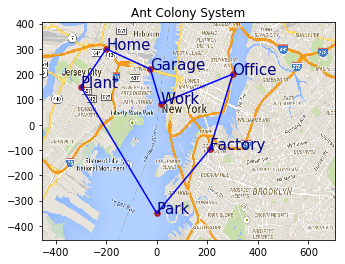

<__main__.Edge instance at 0x00000000098A1A48>
<__main__.Edge instance at 0x00000000098A1548>
<__main__.Edge instance at 0x0000000008F258C8>
<__main__.Edge instance at 0x0000000008F25348>
<__main__.Edge instance at 0x000000000A0C8D88>
<__main__.Edge instance at 0x0000000006E38848>
<__main__.Edge instance at 0x000000000A574A48>
<__main__.Edge instance at 0x000000000A5742C8>
<__main__.Edge instance at 0x000000000A574848>
<__main__.Edge instance at 0x000000000A0C9E88>
<__main__.Edge instance at 0x000000000BEE8688>
<__main__.Edge instance at 0x000000000BEE8948>
<__main__.Edge instance at 0x0000000008B08548>
<__main__.Edge instance at 0x0000000008B08348>
<__main__.Edge instance at 0x0000000008B08A48>
<__main__.Edge instance at 0x00000000091A3088>
<__main__.Edge instance at 0x00000000091A3248>
<__main__.Edge instance at 0x000000000ACCA848>
<__main__.Edge instance at 0x000000000A8BE788>
<__main__.Edge instance at 0x0000000007ED4E48>
<__main__.Edge instance at 0x0000000008FB94C8>
<__main__.Edg

<__main__.Edge instance at 0x000000000A574A48>
<__main__.Edge instance at 0x000000000A5742C8>
<__main__.Edge instance at 0x000000000A574848>
<__main__.Edge instance at 0x000000000A0C9E88>
<__main__.Edge instance at 0x000000000BEE8688>
<__main__.Edge instance at 0x000000000BEE8948>
<__main__.Edge instance at 0x0000000008B08548>
<__main__.Edge instance at 0x0000000008B08348>
<__main__.Edge instance at 0x0000000008B08A48>
<__main__.Edge instance at 0x00000000091A3088>
<__main__.Edge instance at 0x00000000091A3248>
<__main__.Edge instance at 0x000000000ACCA848>
<__main__.Edge instance at 0x000000000A8BE788>
<__main__.Edge instance at 0x0000000007ED4E48>
<__main__.Edge instance at 0x0000000008FB94C8>
<__main__.Edge instance at 0x00000000098A1A48>
<__main__.Edge instance at 0x00000000098A1548>
<__main__.Edge instance at 0x0000000008F258C8>
<__main__.Edge instance at 0x0000000008F25348>
<__main__.Edge instance at 0x000000000A0C8D88>
<__main__.Edge instance at 0x0000000006E38848>
<__main__.Edg

<__main__.Edge instance at 0x00000000098A1548>
<__main__.Edge instance at 0x0000000008F258C8>
<__main__.Edge instance at 0x0000000008F25348>
<__main__.Edge instance at 0x000000000A0C8D88>
<__main__.Edge instance at 0x0000000006E38848>
<__main__.Edge instance at 0x000000000A574A48>
<__main__.Edge instance at 0x000000000A5742C8>
<__main__.Edge instance at 0x000000000A574848>
<__main__.Edge instance at 0x000000000A0C9E88>
<__main__.Edge instance at 0x000000000BEE8688>
<__main__.Edge instance at 0x000000000BEE8948>
<__main__.Edge instance at 0x0000000008B08548>
<__main__.Edge instance at 0x0000000008B08348>
<__main__.Edge instance at 0x0000000008B08A48>
<__main__.Edge instance at 0x00000000091A3088>
<__main__.Edge instance at 0x00000000091A3248>
<__main__.Edge instance at 0x000000000ACCA848>
<__main__.Edge instance at 0x000000000A8BE788>
<__main__.Edge instance at 0x0000000007ED4E48>
<__main__.Edge instance at 0x0000000008FB94C8>
<__main__.Edge instance at 0x00000000098A1A48>
<__main__.Edg

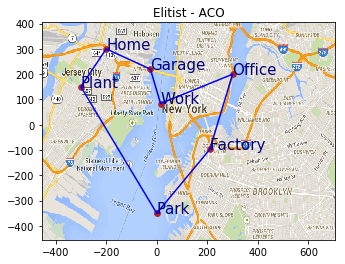

In [286]:
#%matplotlib inline
import csv
import math
import random
from matplotlib import pyplot as plt


def retrieveData():
    data = list(csv.reader(open('datafile.csv')))
    for i in data:
        i[0] = float(i[0])
        i[1] = float(i[1])
    lattitude = [i[0] for i in data]
    longitude = [i[1] for i in data]
    coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
    places = [i[2] for i in data]
    return coordinates, places

class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='Ant Colony System', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, labels=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else: #numbers labels if not assigned a name
            self.labels = range(1, self.num_nodes + 1) 
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    print (str(self.edges[i][j]))

    def _max_min(self):
        for step in range(self.steps):
            iteration_best_tour = None
            iteration_best_distance = float("inf")
            for ant in self.ants:
                ant.find_tour()
                if ant.get_distance() < iteration_best_distance:
                    iteration_best_tour = ant.tour
                    iteration_best_distance = ant.distance
            if float(step + 1) / float(self.steps) <= 0.75:
                self._add_pheromone(iteration_best_tour, iteration_best_distance)
                max_pheromone = self.pheromone_deposit_weight / iteration_best_distance
            else:
                if iteration_best_distance < self.global_best_distance:
                    self.global_best_tour = iteration_best_tour
                    self.global_best_distance = iteration_best_distance
                self._add_pheromone(self.global_best_tour, self.global_best_distance)
                max_pheromone = self.pheromone_deposit_weight / self.global_best_distance
            min_pheromone = max_pheromone * self.min_scaling_factor
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    if self.edges[i][j].pheromone > max_pheromone:
                        self.edges[i][j].pheromone = max_pheromone
                    elif self.edges[i][j].pheromone < min_pheromone:
                        self.edges[i][j].pheromone = min_pheromone

    def run(self):
        #print('Started : {0}'.format(self.mode))
        if self.mode == 'Ant Colony System':
            self._acs()
        elif self.mode == 'Elitist - ACO':
            self._elitist()
        #else:
        #    self._max_min()
        #print('Ended : {0}'.format(self.mode))
        #self._acs()
        print('Sequence : <- {0} ->'.format(' - '.join(str(self.labels[i]) for i in self.global_best_tour)))
        print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2)))

    def plot(self, line_width=1.5, point_radius=math.sqrt(2.5), annotation_size=15, dpi=120, save=True, name=None):
        img = plt.imread('ny-map.jpg')
        #img = plt.imread('dearborn_test1.PNG')
        fig, ax = plt.subplots()
        #x = range(300)
        ax.imshow(img, extent=[-455, 705, -455, 405])
        #ax.imshow(img, extent=[-455, 2600, -455, 1200])
        #ax.plot(x, x, '--', linewidth=5, color='firebrick')
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width, color='blue')#color='firebrick')
        plt.scatter(x, y, s=math.pi * (point_radius ** 5.0), color='firebrick')
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size, color='navy')#size=annotation_size)
        if save:
            if name is None:
                name = '{0}_tour.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()


if __name__ == '__main__':
    coordinates, places = retrieveData()
    _colony_size = 5
    _steps = 150
    _nodes = coordinates#[(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    #_nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    acs = SolveTSPUsingACO(mode='Ant Colony System', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places)# labels=['a', 'b', 'c', 'd', 'e', 'f'])
    acs.run()
    acs.plot()
    elitist = SolveTSPUsingACO(mode='Elitist - ACO', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places)
    elitist.run()
    elitist.plot()
    #max_min = SolveTSPUsingACO(mode='MaxMin', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    #max_min.run()
    #max_min.plot()


Sequence : <-> Factory <-> Office <-> Work <-> Garage <-> Home <-> Plant <-> Park <->
Total distance travelled to complete the tour : 2036.43



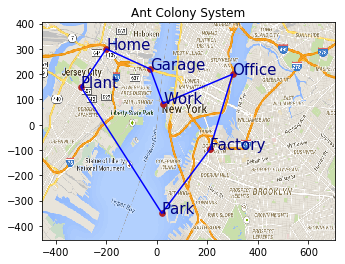

Sequence : <-> Factory <-> Office <-> Work <-> Garage <-> Home <-> Plant <-> Park <->
Total distance travelled to complete the tour : 2036.43



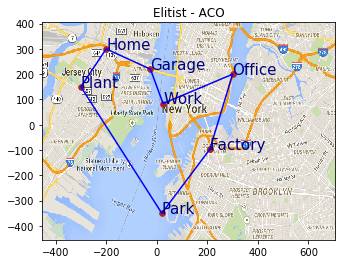

In [308]:
#%matplotlib inline
import csv
import math
import random
from matplotlib import pyplot as plt


def retrieveData():
    data = list(csv.reader(open('datafile.csv')))
    for i in data:
        i[0] = float(i[0])
        i[1] = float(i[1])
    lattitude = [i[0] for i in data]
    longitude = [i[1] for i in data]
    coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
    places = [i[2] for i in data]
    return coordinates, places

class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='Ant Colony System', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, labels=None, previous_path=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    #print (self.edges[i][j].pheromone)
            #print ('\n \n -------------------------- \n \n')

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def run(self):
        #print('Started : {0}'.format(self.mode))
        if self.mode == 'Ant Colony System':
            self._acs()
        elif self.mode == 'Elitist - ACO':
            self._elitist()
        #else:
        #    self._max_min()
        #print('Ended : {0}'.format(self.mode))
        #self._acs()
        print('Sequence : <-> {0} <->'.format(' <-> '.join(str(self.labels[i]) for i in self.global_best_tour)))
        #csv_string = '{0}'.format((', '.join(str(self.labels[i]) for i in self.global_best_tour)))
        #print (csv_string)
        csv_str = [self.labels[i] for i in self.global_best_tour]
        with open("prevTour.csv",'wb') as resultFile:
            wr = csv.writer(resultFile, dialect='excel')
            wr.writerow(csv_str)
        #with open(<path to output_csv>, "wb") as csv_file:
        #    writer = csv.writer(csv_file, delimiter=',')
        #    for line in data:
        #        writer.writerow(line)
        print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2)))

    def plot(self, line_width=1.5, point_radius=math.sqrt(2.5), annotation_size=15, dpi=120, save=True, name=None):
        img = plt.imread('ny-map.jpg')
        #img = plt.imread('dearborn_test1.PNG')
        fig, ax = plt.subplots()
        #x = range(300)
        ax.imshow(img, extent=[-455, 705, -455, 405])
        #ax.imshow(img, extent=[-455, 2600, -455, 1200])
        #ax.plot(x, x, '--', linewidth=5, color='firebrick')
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width, color='blue')#color='firebrick')
        plt.scatter(x, y, s=math.pi * (point_radius ** 5.0), color='firebrick')
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size, color='navy')#size=annotation_size)
        if save:
            if name is None:
                name = '{0}_tour.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()


if __name__ == '__main__':
    coordinates, places = retrieveData()
    _colony_size = 5
    _steps = 150
    _nodes = coordinates#[(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    #_nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    acs = SolveTSPUsingACO(mode='Ant Colony System', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places)# labels=['a', 'b', 'c', 'd', 'e', 'f'])
    acs.run()
    acs.plot()
    elitist = SolveTSPUsingACO(mode='Elitist - ACO', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places)
    elitist.run()
    elitist.plot()
    #max_min = SolveTSPUsingACO(mode='MaxMin', colony_size=_colony_size, steps=_steps, nodes=_nodes)
    #max_min.run()
    #max_min.plot()
